<a href="https://colab.research.google.com/github/forallx94/what_i_did/blob/master/log_analysis_official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Autoencoder-for-HTTP-Log-Anomaly-Detection

* 원본 링크 : https://github.com/zpettry/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection
---
\\
인터넷 Log 데이터를 이용하여 Anomaly Detection 진행.
Autoencoder 를 기준으로 진행

In [ ]:
%cd '/content/drive/MyDrive/log anomaly detection/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection'

/content/drive/MyDrive/log anomaly detection/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection


In [ ]:
!pip install -q keras
!pip install -q pandas
!pip install -q numpy
!pip install -q hyperopt
!pip install -q hyperas

In [ ]:
# 파일 확인

!ls "./"
import os
os.chdir("./")

LICENSE			     log_model-testing.h5  README.md	 weblog.csv
log-analysis-official.ipynb  outliers.txt	   webLog_0.csv


In [ ]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input
import numpy as np
import pandas as pd

In [ ]:
"""
This file is for training on the webLog data.
"""

In [ ]:
# Preprocess webLog.csv and get rid of the Time column.
log = './weblog.csv'
log = pd.read_csv(log)
log = log.drop(['Time'], axis=1)

samples = []
for row in log.iterrows():
    index, data = row
    samples.append(data.tolist())

In [ ]:
log

,IP,URL,Staus
0,10.128.2.1,GET /login.php HTTP/1.1,200
1,10.128.2.1,POST /process.php HTTP/1.1,302
2,10.128.2.1,GET /home.php HTTP/1.1,200
3,10.131.2.1,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200
...,...,...,...
16002,10.130.2.1,GET /showcode.php?id=309&nm=ham05 HTTP/1.1,200
16003,10.130.2.1,GET /allsubmission.php HTTP/1.1,200
16004,10.130.2.1,GET /showcode.php?id=309&nm=ham05 HTTP/1.1,200
16005,10.130.2.1,GET /allsubmission.php HTTP/1.1,200


In [ ]:
max_words = 20000
maxlen = 3

In [ ]:
# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 343 unique tokens.


In [ ]:
# Split data into training and test set. 
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

x = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='log_model-testing.h5',
    monitor='val_loss',
    save_best_only=True
    )
]

In [ ]:
# Create model.
input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(2, activation='relu')(input)
encode = Dense(1, activation='relu')(encode)

decode = Dense(2, activation='relu')(encode)
decode = Dense(3, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(x, x,
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
401/401 [==============================] - 1s 2ms/step - loss: 611.1610 - accuracy: 0.7042 - val_loss: 594.7858 - val_ac

In [ ]:
import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([x, x_test])

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,16006.000000
mean,600.106770
std,2926.848688
min,8.666915
25%,17.667220
50%,49.333911
75%,177.667872
max,72189.698100


In [ ]:
error_df.quantile(0.99)

reconstruction_error    14029.675398
Name: 0.99, dtype: float64

(array([1.5766e+04, 1.4300e+02, 5.4000e+01, 4.0000e+01, 1.0000e+00,
        0.0000e+00, 2.0000e+00]),
 array([8.66691479e+00, 1.03202428e+04, 2.06318187e+04, 3.09433946e+04,
        4.12549704e+04, 5.15665463e+04, 6.18781222e+04, 7.21896981e+04]),
 <a list of 7 Patch objects>)

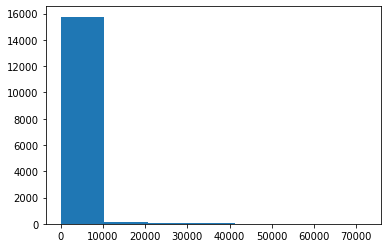

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

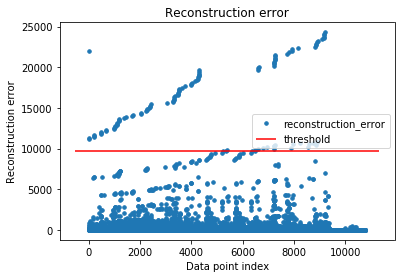

200
GET /madeup.php HTTP/1.1
10.4.5.2
----------------------------------
GET /profile.php?user=bala HTTP/1.1
10.130.2.1
200
----------------------------------
GET /edit.php?name=bala HTTP/1.1
10.131.2.1
200
----------------------------------
10.131.2.1
200
GET /contestproblem.php?name=Toph%20Contest%202 HTTP/1.1
----------------------------------
10.131.2.1
GET /details.php?id=3 HTTP/1.1
200
----------------------------------
10.131.2.1
200
GET /contestsubmission.php?id=4 HTTP/1.1
----------------------------------
10.131.2.1
200
GET /edit.php?name=ksrsingh HTTP/1.1
----------------------------------
200
GET /showcode.php?id=285&nm=ksrsingh HTTP/1.1
10.131.0.1
----------------------------------
GET /allsubmission.php?name=shawon HTTP/1.1
200
10.128.2.1
----------------------------------
200
10.129.2.1
GET /login.php HTTP/1.0
----------------------------------
10.131.2.1
302
GET / HTTP/1.0
----------------------------------
GET /profile.php?user=moshiur_cse15 HTTP/1.1
200
10.131.0.1
---

In [ ]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])
  
for x in output:
    for key, value in word_index.items():
        if value == x[2]:
            print(key)
        if value == x[1]:
            print(key)
        if value == x[0]:
            print(key)
    print('----------------------------------')


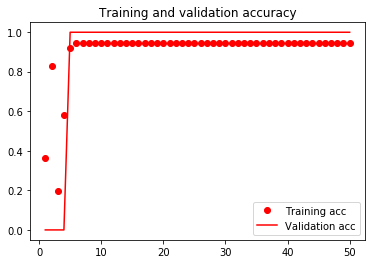

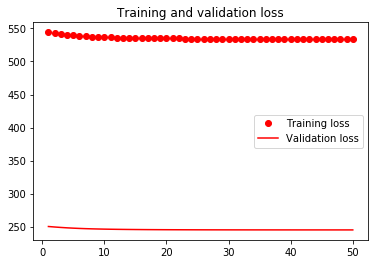

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()